# Tomograf

## Autorzy:

1. Maciej Kleban (147031)
2. Marek Pietkiewicz (147032)

Grupa L15 (środa 15:10)

Język : **Python**

##### Instalacja wymaganych pakietów (uruchamiane tylko raz)

Wykorzystane pakiety to:
* matplotlib - pokazywanie obrazu oraz wykresów
* skimage - w celu konwersji obrazu na macierz pikseli (wczytanie do pamięci)
* numpy - do operacji na macierzach
* math - do wyliczenia wartości sinus, cosinus i pi
* pydicom - do zapisu danych w pliku .dcm w formacie DICOM
* sklearn - błąd średnio kwadratowy

In [4]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install ipywidgets
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn

from skimage import io
from skimage.color import rgb2gray
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import math
import pydicom as dicom
import time

from IPython.display import clear_output

clear_output()

## 0. Parametry symulacji

Parametrami symulacji są:
* Liczba kroków
* Liczba detektorów
* Rozpiętość wachlarza

Jeżeli interesuje nas zmiana kąta alfa ($\Delta \alpha$), to jest ona obliczana poprzez: max_angle/steps, gdzie max_angle bazowo jest ustawiony na $180^{\circ} $

Parametry ustawia się poprzez suwaki. By one się pojawiły trzeba skompilować poniższą komórkę. Podobnie w przypadku interaktywnego formularza do zapisywania pliku DICOM.

In [52]:
import ipywidgets as widgets

nrays = widgets.IntSlider(value=270, min=90, max=719, step=90, description="Liczba detektorów   :", style={'description_width': '150px'})
steps = widgets.IntSlider(value=90, min=90, max=719, step=90, description="Liczba kroków       :", style={'description_width': '150px'})
spann = widgets.IntSlider(value=135, min=45, max=269, step=45, description="Rozpiętość wachlarza :", style={'description_width': '150px'})
pbtn = widgets.Button(description='Zapisz parametry')

def handler(obj):
    global NUM_RAYS
    global SPAN
    global STEPS
    NUM_RAYS = nrays.value
    SPAN = spann.value
    STEPS = steps.value

NUM_RAYS = 270
STEPS = 90
SPAN = 135

display(nrays, steps, spann, pbtn)
    
pbtn.on_click(handler)

IntSlider(value=270, description='Liczba detektorów   :', max=719, min=90, step=90, style=SliderStyle(descript…

IntSlider(value=90, description='Liczba kroków       :', max=719, min=90, step=90, style=SliderStyle(descripti…

IntSlider(value=135, description='Rozpiętość wachlarza :', max=269, min=45, step=45, style=SliderStyle(descrip…

Button(description='Zapisz parametry', style=ButtonStyle())

## 1. Model emiter/detektor

Do obliczenia pozycji emitera wykorzystano wzory ze strony przedmiotu Informatyka w Medycynie:

$$x = r \times cos(\alpha)$$
$$y = r \times sin(\alpha)$$

Jako, że wykorzystano **model równoległy** należy obliczyć pozycję emitera dla każdego detektora, co powoduje że wzór zmienia się na:

$$x_d = r \times cos(\alpha - (i \times \frac{\phi}{n-1}) + \frac{\phi}{2})$$
$$y_d = r \times sin(\alpha - (i \times \frac{\phi}{n-1}) + \frac{\phi}{2})$$

Natomiast pozycja detektora jest obliczona za pomocą standardowego wzoru:

$$x_e = r \times cos(\alpha + \pi - \frac{\phi}{2} + (i \times \frac{\phi}{n-1}))$$
$$y_e = r \times sin(\alpha + \pi - \frac{\phi}{2} + (i \times \frac{\phi}{n-1}))$$

Gdzie:

$r$ - promień okręgu na podstawie którego obliczane są pozycje promienii

$\alpha$ - określa miejsce, z jakiego promień pada (funkcja kąta)

$\phi$ - rozpiętość kątowa zestawu promieni

Należy wziąć również pod uwagę to, że oś współrzędnych w wizualizacji za pomocą biblioteki matplotlib jest przesunięta, więc należy to uwzględnić podczas obliczania punktów i dodać przesunięcie do ich pozycji.

In [53]:
# Rysuj promienie równoległe projektora
def get_parallel_rays(radius, pos, angle=45, span=120, num_rays=20):
    alpha = math.radians(angle)
    theta = math.radians(span)

    rays = []
    for ray in range(num_rays):
        # punkty detektorów
        x_d = radius * math.cos(alpha - (ray * theta/(num_rays-1)) + theta/2) + pos[0]
        y_d = radius * math.sin(alpha - (ray * theta/(num_rays-1)) + theta/2) + pos[1]
        # punkty emiterów
        x_e = radius * math.cos(alpha + math.pi - (theta/2) + (ray * theta/(num_rays-1))) + pos[0]
        y_e = radius * math.sin(alpha + math.pi - (theta/2) + (ray * theta/(num_rays-1))) + pos[1]
        rays.append([[x_d, x_e], [y_d, y_e]])
    
    return rays

### Wizualizacja równoległych skanerów

Okrąg po promieniu $0.4$, 50 promieni pada pod kątem $\alpha = 45^0$, rozpiętość promieni wynosi $180^0$. Przesunięcie empirycznie wyznaczone jako $0.6$ jednostek na koordynacie $x$ i $y$ w celu lepszej wizualizacji.

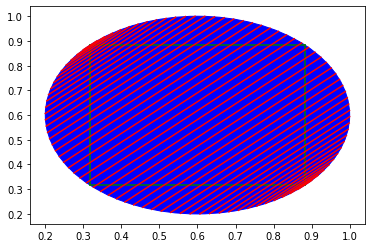

In [54]:
# Przesunięcie
pos = (0.6, 0.6)
r = 0.4
alpha = 45
# Rozpiętość kątowa
span = 180
num_rays = 50

circle = plt.Circle(pos, r, color='blue')
fig, ax = plt.subplots()

ax.add_patch(circle)

# Długość boku kwadratu obramowania obrazu
edge = math.sqrt(r * r * 2)

# Koordynaty obrazu
x_1 = pos[0] - (edge/2)
x_e = pos[0] - (edge/2) + edge
y_1 = pos[1] - (edge/2)
y_e = pos[1] - (edge/2) + edge

# Obramowanie obrazu
a = [[x_1, x_e], [y_1, y_1]]
b = [[x_1, x_1], [y_1, y_e]]
c = [[x_1, x_e], [y_e, y_e]]
d = [[x_e, x_e], [y_1, y_e]]

# Rysowanie obramowania
ax.plot(a[0], a[1], color="green")
ax.plot(b[0], b[1], color="green")
ax.plot(c[0], c[1], color="green")
ax.plot(d[0], d[1], color="green")

rays = get_parallel_rays(r, pos, alpha, span, num_rays)

# Rysuj linie projektora
for ray in rays:
    ax.plot([ray[0][0], ray[0][1]], [ray[1][0], ray[1][1]], color="red")

plt.show()

## 2. Transformata Radona - obliczanie sinogramu

### Obliczanie punktów Bresenhama

Aby wyznaczyć sinogram należy obliczyć jasność pikseli w punktach leżących na promieniu emiter-detektor. Do tego wykorzystano algorytm Bresenhama:

In [55]:
# Algorytm Bresenhama
def get_bresenham_points(x1, x2, y1, y2):
    # Normalizacja do liczb całkowitych
    x1, y1 = int(x1), int(y1)
    x2, y2 = int(x2), int(y2)
    dx = x2 - x1
    dy = y2 - y1

    # Sprawdzanie poprawności parametrów w celu zapobiegania błędom
    # -------------------------------------------------------------

    # Określenie osi wiodącej
    is_steep = abs(dy) > abs(dx)

    # Obróć linię jeżeli osią wiodącą jest oś OY - zapobiega to dzieleniu przez zero gdy kąt padania linii jest równy
    # 90 stopni, wówczas zamień koordynaty miejscami (x zamienia się miejscami z y)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Jeżeli podano koordynaty w odwrotnej kolejności, zamień je
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Prawidłowy algorytm
    # -------------------------------------------------------------

    # Ponowne obliczanie różnic po sprawdzeniu poprawności
    dx = x2 - x1
    dy = y2 - y1

    # Oblicz błąd pomiarowy
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Obliczanie punktów leżących na linii
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Odwróć listę jeżeli punkty zostały podane na odwrót
    if swapped:
        points.reverse()
    return points

Teraz gdy funkcja na obliczanie pozycji punktów tworzących linię jest zdefiniowany, można przejść do zdefiniowania obliczania sinogramu - __wystarczy więc obliczyć sumę wartości jasności punktów__ wyznaczonych algorytmem Bresenhama i inkrementować kąt padania (sinogram będzie więc funkcją zależności jasności pikseli od kąta):

In [56]:
# steps - ile podziałów kąta ma zostać wykonanych
def calculate_sinogram(img, steps=60, span=120, num_rays=250, max_angle=180):
    # Pusty sinogram
    sinogram = np.zeros((steps, num_rays))
    idx = 0
    # Wykonaj skan obrazu (bazowo 180 stopni - gdyż potem pomiary się powtarzają)
    for idx in range(steps):
        # Wyznacz pozycję detektorów i emiterów dla tego kąta
        angle = idx * (max_angle/steps)
        rays = get_parallel_rays(max(image.shape[0]//2, image.shape[1]//2)*math.sqrt(2),
                                 (image.shape[0]//2, image.shape[1]//2), angle, span, num_rays)
        for ray_idx, ray in enumerate(rays):
            # Sumowanie jasności pikseli leżących na linii
            emitter_value = 0
            points = get_bresenham_points(ray[0][0], ray[0][1], ray[1][0], ray[1][1])
            for point in points:
                # Dodaj tylko punkty obejmujące obraz
                # Ponieważ okrąg promieni jest opisany na obrazie, więc wychodzi poza jego krawędzie
                if (point[0] >= 0 and point[0] < img.shape[0]) and (point[1] >= 0 and point[1] < img.shape[1]):
                    emitter_value += img[point[0]][point[1]]
            sinogram[idx][ray_idx] = emitter_value
    return sinogram

# domyślnie sinogram jest odwrócony, tj. na osi OX występują kąty, a na osi OY wartości jasności promienii - ta funkcja
# odwraca ten wykres
def transpose(sinogram):
    return [list(x) for x in list(zip(*sinogram))]

## Wizualizacja sinogramu

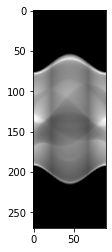

In [57]:
# Obraz do wyliczenia sinogramu
image = io.imread("Shepp_logan.jpg")
image = rgb2gray(image)

sinogram = calculate_sinogram(image, steps=STEPS, span=SPAN, num_rays=NUM_RAYS)
plt.imshow(transpose(sinogram), cmap="gray", aspect='auto')

## 3. Odwrotna transformata Radona (Backprojection)

Aby odwtorzyć obraz należy wykonać operację z obliczania sinogramu ale w przeciwnym kierunku - ponownie obliczane są koordynaty emitera i detektora i wyznaczane są punkty leżąca na linii między nimi, lecz tym razem następuje dodanie do tych pikseli wartości z sinogramu na tej samej pozycji.

Do tego celu wykorzystano również normalizację, która polega na podzieleniu każdej wartości piksela w obrazie wynikowym przez maksymalną wartość jasności piksela w całym sinogramie.

In [58]:
# Normalizacja
def normalize(sinogram, maximum):
    for i in range(len(sinogram)):
        for j in range(len(sinogram[i])):
            sinogram[i][j] = sinogram[i][j] / maximum
    return sinogram


# Backprojection
def reverse_radon_transform(sinogram, steps=60, span=120, num_rays=250, max_angle=180, calc_error=False):
    # Pusty obraz wynikowy
    width = image.shape[0]
    height = image.shape[1]
    out_image = np.zeros((image.shape[0], image.shape[1]))
    error = []
    maximum = -1
    
    for idx in range(steps):
        angle = idx * max_angle/steps
        rays = get_parallel_rays(max(image.shape[0]//2, image.shape[1]//2)*math.sqrt(2),
                                 (image.shape[0]//2, image.shape[1]//2), angle, span, num_rays)
        for ray_idx, ray in enumerate(rays):
            points = get_bresenham_points(ray[0][0], ray[0][1], ray[1][0], ray[1][1])
            for point in points:
                # Dodaj tylko punkty obejmujące obraz
                # Ponieważ okrąg promieni jest opisany na obrazie, więc wychodzi poza jego krawędzie
                if (point[0] >= 0 and point[0] < image.shape[0]) and (point[1] >= 0 and point[1] < image.shape[1]):
                    out_image[point[0]][point[1]] += sinogram[idx][ray_idx]
                    # W celu późniejszej normalizacji
                    if out_image[point[0]][point[1]] > maximum:
                        maximum = out_image[point[0]][point[1]]
        if calc_error:
            error.append(
                mean_squared_error(
                    [item for k in out_image for item in k], [item for k in image for item in k]
                ))
    if not calc_error:
        return normalize(out_image, maximum)
    else: return normalize(out_image, maximum), error

## Wizualizacja odtworzonego obrazu

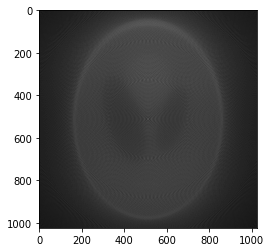

In [59]:
# Obraz do wyliczenia sinogramu i backprojection
image = io.imread("Shepp_logan.jpg")
image = rgb2gray(image)
sinogram = calculate_sinogram(image, steps=STEPS, span=SPAN, num_rays=NUM_RAYS)
out_image = reverse_radon_transform(sinogram, steps=STEPS, span=SPAN, num_rays=NUM_RAYS)
plt.imshow(out_image, cmap="gray")

## 4. Filtrowanie (splot)

W celu pozbycia się artefaktów z odwrotnej transformaty Radona wykorzystano splot.

Splot polega na złożeniu wartości na każdy pixel z części sąsiednich.

W przypadku __sinogramu__ składamy z rzędu pixeli i kernelSize pixeli w linii

W przypadku splotu na __obrazie wyjściowym__ używamy takich samych części pixeli w kwadracie o boku __2 \* shift__,
gdzie __shift to int(kernelSize/2)__.

In [60]:
def convolve_sinogram(img, kernelSize=9):
    width = len(img)
    imgNew = []
    for i in range(width):
        imgNew.append([])
        for j in range(len(img[i])):
            imgNew[i].append(0.0) 
    
    # Stworzenie kernela o rozmiarze kernelSize
    kernelCenter = (int)(kernelSize / 2)
    kernel = []
    # Wypełnienie kernela wartościami:
        # dla środka 1.0
        # dla parzystych elementów 0.0
        # dla pozostałych -4/(pi**2 * (index - środekKernela)**2)
    for i in range(kernelSize):
        if i == kernelCenter:
            kernel.append(1.0)
        elif i % 2 == 0:
            kernel.append(0.0)
        else:
            kernel.append((-4 / pow(math.pi, 2)) / pow(i - kernelCenter, 2))
    width = len(img[0])
    
    # Dla każdego rzędu pixeli w sinogramie złóż wartość pixela [i, j]  
    # z wartości oddalonych o kernelCenter w lewą stronę aż do kernelSize
        # wartość oznaczona kernelCenter to wartość obecnego pixela z wagą 1.0
        # wartości nieparzyste mają wagę 0.0
        # pozostałe wartości mają wagę -4/(pi**2 * (index - środekKernela)**2)
    for i, row in enumerate(img):
        j = kernelCenter
        while j < (width - kernelCenter):
            it = 0
            k = j - kernelCenter
            while it < kernelSize:
                imgNew[i][j] += img[i][k] * kernel[it]
                k += 1
                it += 1
            j += 1
        
    return imgNew

def convolve_image(img, kernelSize=9, width=image.shape[0], height=image.shape[1]):
    imgNew = np.zeros((width, height))
    
    # Stworzenie kernela z zawartością 1/kernelSize**2 (co daje taką samą wagę każdemu pixelowi w kernelu)
    kernel = np.ones((kernelSize, kernelSize))
    kernel /= 1.0 * kernelSize * kernelSize
    
    # Przesunięcie, bazowo równe 4
    shift = (int)((kernelSize-1) / 2)
    m = shift
    
    # Złożenie wartości na pojedynczym pixelu w obrazie 
    # pomniejszonym o shift o wartości w kwadracie 2*shift na 2*shift,
    # gdzie m i n to środek kwadratu.
    while m < (width - shift):
        n = shift
        while n < (height - shift):
            i = m - shift
            while i <= (m + shift):
                j = n - shift
                while j <= (n + shift):
                    imgNew[m][n] += img[i][j] * kernel[m-i][n-j]
                    j += 1
                i += 1
            n += 1
        m += 1
            
    return imgNew

In [61]:
def get_max(sinogram):
    return max([item for k in sinogram for item in k])

### Wizualizacja splotu

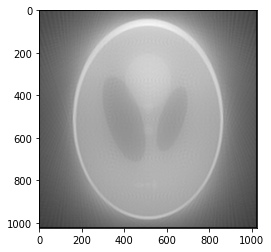

In [62]:
image = io.imread("Shepp_logan.jpg")
image = rgb2gray(image)

sinogram = calculate_sinogram(image, steps=STEPS, span=SPAN, num_rays=NUM_RAYS)
filtered_sinogram = convolve_sinogram(normalize(sinogram, get_max(sinogram)), kernelSize=5)
filtered_image = convolve_image(reverse_radon_transform(filtered_sinogram, steps=STEPS, span=SPAN, num_rays=NUM_RAYS))
plt.imshow(filtered_image, cmap="gray", aspect='equal')

## 5. DICOM

Do zapisu danych o pacjentach służy format DICOM, który odpowiednim tagom przypisuje odpowiednie pola danych pacjenta takich jak imię, płeć, adres, itd. Do zapisu w odpowiednich tagach wykorzystano bibliotekę **pydicom** zgodnie z wymaganiami projektu.

### Zapis

In [63]:
import pydicom as dicom

# Zapis pliku dicom

# patient_data to dane pacjenta w postaci:
# { klucz1 : val1, klucz2 : val2 }
# Wykorzystane klucze:
# PatientName, PatientID, PatientSex, PatientBirthDate, PatientBirthTime, PatientAge
# PatientWeight, PatientSize, PatientAddress, PatientTelephoneNumbers

# Study_date - data badania (datetime)
# Comments - komentarze (string)
def save_dicom(patient_data = {}, study_date = None, comments = None, image = None, filename = "document.dcm"):
    
    if not filename.endswith(".dcm"):
        print("Incorrect file format.")
        return

    ds = dicom.dataset.FileDataset(filename, {}, preamble=b"\0" * 128)

    # Zapisywanie danych pacjenta
    for key in patient_data.keys():
        setattr(ds, key, patient_data[key])

    # Zapis daty badania i komentarzy
    if study_date:
        ds.StudyDate = study_date
    
    if comments:
        ds.PatientComments = comments
    
    # Zapis obrazu
    if image is not None:
        ds.PixelData = image.tobytes()
        # Zapis rozmiarów obrazu
        ds.Rows = image.shape[0]
        ds.Columns = image.shape[1]
    
    ds.set_original_encoding(True, True, ["utf-8"])
    # Pozwól na polskie znaki
    ds.SpecificCharacterSet = 'utf-8'
    
    # Zapisz dane zaczynając od najmniej znaczącego bitu
    ds.is_little_endian = True
    # Zapisz bez specyfikacji VR
    ds.is_implicit_VR = True
            
    ds.save_as(filename)

### Odczyt

In [64]:
# Odczyt pliku dicom
def read_dicom(filename = "document.dcm"):
    
    # Wyświetl dane pacjenta
    ds = dicom.dcmread(filename, force=True)
    print(ds)
    
    # Wyświetl obraz
    try:
        img = ds.PixelData
        img = np.ndarray((ds.Rows, ds.Columns), np.float64, img)
        fig, ax = plt.subplots()
        ax.imshow(img, cmap='gray')
    except AttributeError:
        pass

### Przykład

(0008, 0005) Specific Character Set              CS: 'utf-8'
(0010, 0010) Patient's Name                      PN: 'Próbny pacjent'
(0010, 0020) Patient ID                          LO: '123456'
(0028, 0010) Rows                                US: 1024
(0028, 0011) Columns                             US: 1024
(7fe0, 0010) Pixel Data                          OW: Array of 8388608 elements


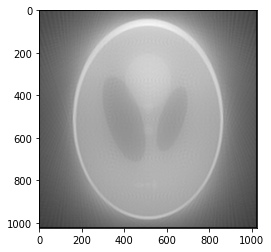

In [65]:
import os
import datetime

image = io.imread("Shepp_logan.jpg")
image = rgb2gray(image)
if filtered_image is None:
    sinogram = calculate_sinogram(image, steps=60)
    filtered_sinogram = convolve_sinogram(normalize(sinogram, get_max(sinogram)), kernelSize=5)
    filtered_image = convolve_image(reverse_radon_transform(filtered_sinogram))

data = {"PatientName": "Próbny pacjent", "PatientID": "123456"}

# Zapisz obraz i dane pacjenta do pliku DICOM
save_dicom(data, image=filtered_image)

# Odczytaj plik DICOM i wyświetl obraz
read_dicom()

# Usuń utworzony plik DICOM
os.remove("document.dcm")

### Interaktywna generacja pliku

Poniższy kod umożliwia interaktywną generację pliku .dcm w formacie DICOM zawierającym podane dane o pacjencie oraz
zdjęcie z podanej ścieżki.

Data badania, nazwa pliku wyjściowego oraz wejściowego są obowiązkowe, pozostałe parametry są opcjonalne. Po
uzupełnieniu danych należy wcisnąć przycisk **Save as DICOM** i odczekać aż program wygeneruje plik lub
zwróci błąd.

In [66]:
import ipywidgets as widgets

btn = widgets.Button(description='Save as DICOM')

exam_date = widgets.DatePicker(description="Data badania")
name = widgets.Text(value="", description="Imię")
patient_id = widgets.Text(value="", description='ID')
sex = widgets.Dropdown(options=["", "K", "M"], value="", description='Płeć')
birth_date = widgets.DatePicker(description='Data urodzenia')
height = widgets.IntText(value=0, description="Wzrost (cm)")
address = widgets.Text(value="", description="Adres")
telephone = widgets.Text(value="", description="Telefon")
filepath = widgets.Text(value="Shepp_logan.jpg", description="Plik")
comments = widgets.Textarea(value="", placeholder="", description='Komentarze')
output = widgets.Text(value="document.dcm", description="Plik wynikowy")

display(exam_date, name, patient_id, sex, birth_date, height, address, telephone, comments, filepath, output, btn)

def btn_eventhandler(obj):
    if exam_date.value is None:
        print("Nie podano daty badania!")
        return
    if filepath.value == "":
        print("Nie podano pliku wejściowego!")
        return
    if output.value == "":
        print("Nie podano pliku wyjściowego!")
        return

    # Zapisz dane pacjenta
    data = {}
    if name.value != "":
        data["PatientName"] = name.value
    if patient_id.value != "":
        data["PatientID"] = patient_id.value
    if sex.value != "":
        data["PatientSex"] = sex.value
    if birth_date.value is not None:
        data["PatientBirthDate"] = birth_date.value
        data["PatientAge"] = str(datetime.datetime.now().date().year - birth_date.value.year)
    if height.value > 0:
        data["PatientSize"] = str(height.value)
    if address.value != "":
        data["PatientAddress"] = address.value
    if telephone.value != "":
        data["PatientTelephoneNumbers"] = telephone.value
        
    print(f"Saving sinogram of image {filepath.value} to file {output.value}...")
    
    image = io.imread(filepath.value)
    image = rgb2gray(image)
    
    sinogram = calculate_sinogram(image, steps=60)
    filtered_sinogram = convolve_sinogram(normalize(sinogram, get_max(sinogram)), kernelSize=5)
    filtered_image = convolve_image(reverse_radon_transform(filtered_sinogram))

    save_dicom(data, exam_date.value, comments.value, filtered_image, output.value)
    
    print("Saved!")

btn.on_click(btn_eventhandler)

DatePicker(value=None, description='Data badania')

Text(value='', description='Imię')

Text(value='', description='ID')

Dropdown(description='Płeć', options=('', 'K', 'M'), value='')

DatePicker(value=None, description='Data urodzenia')

IntText(value=0, description='Wzrost (cm)')

Text(value='', description='Adres')

Text(value='', description='Telefon')

Textarea(value='', description='Komentarze', placeholder='')

Text(value='Shepp_logan.jpg', description='Plik')

Text(value='document.dcm', description='Plik wynikowy')

Button(description='Save as DICOM', style=ButtonStyle())

In [ ]:
# Odczytaj zapisany plik DICOM
read_dicom(output.value)

## 6. Statystyki

Używaną przez nas statystyką jest błąd średniokwadratowy. Błąd obliczamy z pomocą biblioteki sklearn (gotowa funkcja przyjmująca dwie listy). 

Statystyki obliczamy na podstawie 3 metod:

* Zmiana błędu pomiędzy każdą iteracją odwrotnej transformaty Radona a obrazem wejściowym
* Obraz wejściowy i wyjściowy
* Obraz wejściowy i wyjściowy z użyciem splotu (na sinogramie i obrazie wyjściowym)
* Obraz wejściowy i wyjściowy dla zakresu danych:
    * Liczba skanów: <90, 720) z przejściem 90
    * Liczba detektorów: <90, 720) z przejściem 90
    * Rozpiętość wachlarza: <45, 270) z przejściem 45

Statystyki były liczone dla Fantomu Shepp–Logan

### Zmiana błędu pomiędzy każdą iteracją odwrotnej transformaty Radona (z użyciem splotu na sinogramie) a obrazem wejściowym

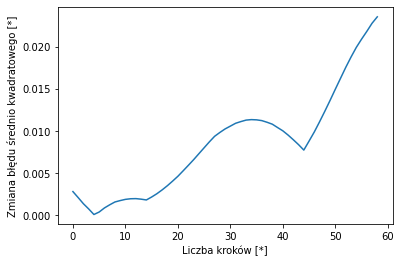

In [68]:
sinogram = calculate_sinogram(image, steps=60)
filtered_sinogram = convolve_sinogram(normalize(sinogram, get_max(sinogram)), kernelSize=5)
_, error = reverse_radon_transform(filtered_sinogram, steps=60, calc_error=True)
out_error = []
for e in range(len(error) - 1):
    out_error.append(abs(error[e + 1] - error[e]))
plt.plot(out_error)
plt.xlabel('Liczba kroków [*]')
plt.ylabel('Zmiana błędu średnio kwadratowego [*]')
plt.show()

### Obraz wejściowy i wyjściowy

In [69]:
STEPS = 360
NUM_RAYS = 360
SPAN = 270
out_image = reverse_radon_transform(
        normalize(
            calculate_sinogram(image, steps=STEPS, span=SPAN, num_rays=NUM_RAYS), get_max(sinogram)), 
    steps=STEPS, span=SPAN, num_rays=NUM_RAYS)

print(mean_squared_error(
        [item for k in out_image for item in k],
        [item for k in image for item in k]
    ))

0.0397527005562687


### Obraz wejściowy i wyjściowy z użyciem splotu (na sinogramie i obrazie wyjściowym)

In [70]:
STEPS = 360
NUM_RAYS = 360
SPAN = 270
out_image = convolve_image(
    reverse_radon_transform(
        convolve_sinogram(
            normalize(
                calculate_sinogram(image, steps=STEPS, span=SPAN, num_rays=NUM_RAYS), get_max(sinogram)), kernelSize=5), 
        steps=STEPS, span=SPAN, num_rays=NUM_RAYS)
)
print(mean_squared_error(
        [item for k in out_image for item in k],
        [item for k in image for item in k]
    ))

0.03619646264124903


### Obliczanie statystyk dla pełnego zakresu danych

Generowanie błędu zostało wyłączone z powodu czasochłonności, przy wrzuceniu folderu error_base z plikami wynikowymi można wygenerować wykresy za pomocą komórki 2 niżej.

In [71]:
STEPS_RANGE = list(range(90, 720, 90))
NUM_RAYS_RANGE = list(range(90, 720, 90))
SPAN_RANGE = list(range(45, 270, 45))
it = 0
errors = []
elapsed = [] 
if False: # Generowanie wyników zostało wyłączone z powodu czasochłonności (~10 godzin)
    for STEPS in STEPS_RANGE:
        start = time.time()
        error_base = []
        for i, NUM_RAYS in enumerate(NUM_RAYS_RANGE):
            error_base.append([])
            for SPAN in SPAN_RANGE:
                it+=1
                start = time.time()
                sinogram = calculate_sinogram(image, steps=STEPS, span=SPAN, num_rays=NUM_RAYS, max_angle=360)
                out_image = reverse_radon_transform(sinogram, steps=STEPS, span=SPAN, num_rays=NUM_RAYS, max_angle=360)
                error_base[i].append(
                    mean_squared_error(
                        [item for k in image for item in k], [item for k in out_image for item in k]
                    )
                )
                end = time.time()
                elapsed.append(end-start)
                if len(elapsed) > 10:
                    elapsed.pop(0)
                print(f'Iteration: {it}; Elapsed time: {end-start} sec; Estimated time {(245-it)*np.mean(elapsed)/60}')
                if(it % 10 == 0): clear_output()
        np.savetxt("error_base\\"+str(it) + '.txt', error_base)
        errors.append(error_base)



#### Wyświetlanie powyżej obliczonych statystyk

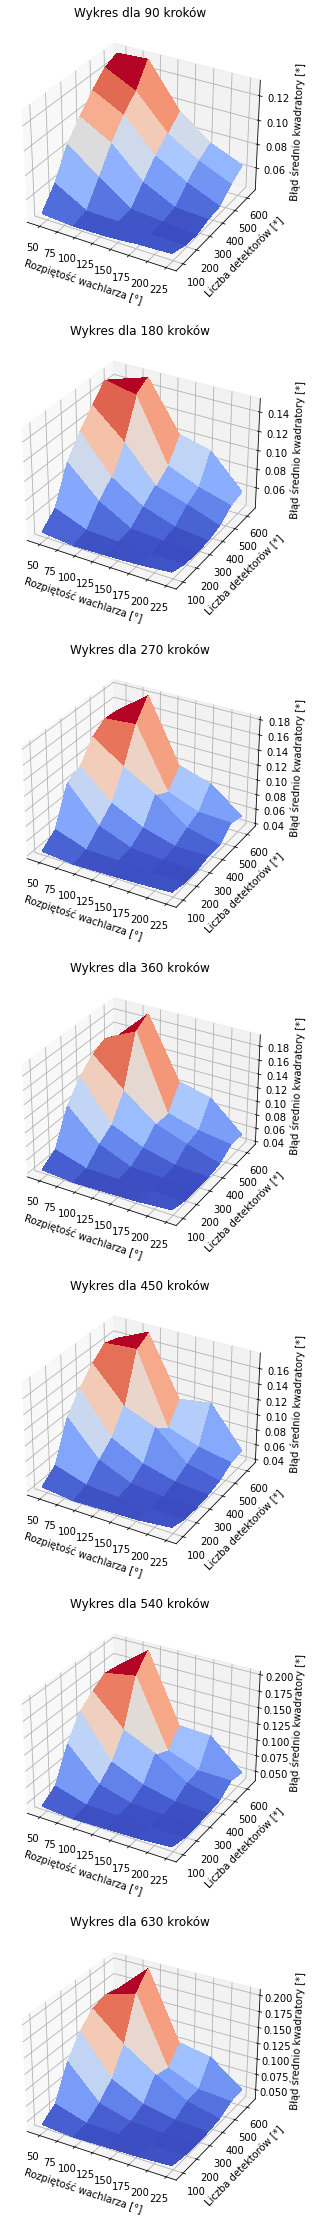

In [72]:
from matplotlib import cm

X, Y = np.meshgrid(SPAN_RANGE, NUM_RAYS_RANGE)

fig, axes = plt.subplots(len(range(90, 720, 90)), subplot_kw={"projection": "3d"}, figsize=(40, 40))
files = ['35', '70', '105', '140', '175', '210', '245']
for i, STEPS in enumerate(STEPS_RANGE):
    data = np.loadtxt('error_base\\' + files[i] + '.txt')
    axes[i].set_title('Wykres dla '+str(STEPS)+' kroków')
    axes[i].set_xlabel('Rozpiętość wachlarza [°]')
    axes[i].set_ylabel('Liczba detektorów [*]')
    axes[i].set_zlabel('Błąd średnio kwadratory [*]')
    axes[i].plot_surface(X, Y, data, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

### Różnice pomiędzy obrazem wynikowym bez i z użyciem splotu

Największa różnicą pomiędzy tymi obrazami jest widoczność szczegółów na korzyść obrazu ze splotem. Obraz co prawda jest przejaśniony, aczkolwiek splot polepsza jakość wyniku